In [1]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import register_keras_serializable
from sklearn.model_selection import StratifiedKFold
import os
import cv2
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create Model

In [3]:
def create_model(input_shape, num_classes):
  base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(input_shape[2], input_shape[3], 3))

  input = layers.Input(shape=input_shape[1:])
  x = layers.TimeDistributed(base_model)(input)
  x = layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
  x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
  x = layers.Dropout(0.4)(x)

  x = layers.GlobalAveragePooling3D()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.6)(x)
  x = layers.Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=input, outputs=x)
  return model

In [4]:
input_shape = (None, 12, 360, 360, 3)
number_of_classes = 16

model = create_model(input_shape, number_of_classes)
model.compile(loss = SparseCategoricalCrossentropy(),
              optimizer = Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 360, 360, 3   0         
                             )]                                  
                                                                 
 time_distributed (TimeDist  (None, 12, 12, 12, 2048   23564800  
 ributed)                    )                                   
                                                                 
 conv3d (Conv3D)             (None, 12, 12, 12, 64)    3539008   
                                                                 
 max_pooling3d (MaxPooling3  (None, 6, 6, 6, 64)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 6, 6, 6, 64)       0         
                                                             

## Callbacks

In [5]:
ACCURACY_THRESHOLD = 0.97

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('accuracy') > ACCURACY_THRESHOLD:
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super(SaveModelCallback, self).__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy > 0.98:
            print("\nValidation accuracy is more than 98%, saving model.")
            self.model.save(self.save_path)

# Define the save path for the model
save_path =  "/content/drive/Shareddrives/ML Project/Models/resnet50v2_regularized.h5"

callbacks = [myCallback(), SaveModelCallback(save_path)]

# Load Dataset and Train Model

## Load Dataset

In [6]:
train_dataset_path = "/content/drive/Shareddrives/ML Project/Dataset/Train"
X_paths = []
Y_labels = []

for video_file in os.listdir(train_dataset_path):
    if video_file.lower().endswith(('.mov', '.mp4')):
        video_path = os.path.join(train_dataset_path, video_file)
        X_paths.append(video_path)
        Y_labels.append(video_file.split("_")[0])

X_paths = np.array(X_paths)
Y_labels = np.array(Y_labels, dtype='U2')

In [7]:
label_mapping = {}
for idx, label in enumerate(np.sort(np.unique(Y_labels))):
      label_mapping[label] = idx

In [8]:
def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (360, 360), interpolation=cv2.INTER_LINEAR)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert frame to grayscale
        frame = frame / 255.0  # Normalize pixel values
        yield frame
    cap.release()

In [9]:
def video_to_dataset(video_path):
    frames = list(load_video(video_path))
    video_tensor = np.array(frames, dtype=np.float32)
    return video_tensor

In [10]:
def load_dataset(video_paths, labels):

    def generator():
        for video_path, label in zip(video_paths, labels):
            yield video_to_dataset(video_path), label_mapping[label]

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.int32),
        output_shapes=((12, 360, 360, 3), ())
    )
    return dataset

## Train Model

In [11]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [12]:
count = 1

for train, validation in kfold.split(X_paths, Y_labels):
    print("K Fold Step  ", count)
    train_data = load_dataset(X_paths[train], Y_labels[train]).batch(10).prefetch(tf.data.experimental.AUTOTUNE)
    validation_data = load_dataset(X_paths[validation], Y_labels[validation]).batch(10).prefetch(tf.data.experimental.AUTOTUNE)
    model.fit(train_data, validation_data=validation_data, epochs=50, verbose= 1, callbacks=callbacks)
    print(train_data)
    count += 1

K Fold Step   1
Epoch 1/50
34/34 [==============================] - 165s 4s/step - loss: 4.2137 - accuracy: 0.0588 - val_loss: 3.8673 - val_accuracy: 0.0471
Epoch 2/50
34/34 [==============================] - 24s 711ms/step - loss: 3.7821 - accuracy: 0.0735 - val_loss: 3.7578 - val_accuracy: 0.0353
Epoch 3/50
34/34 [==============================] - 25s 727ms/step - loss: 3.5804 - accuracy: 0.1559 - val_loss: 3.4833 - val_accuracy: 0.1471
Epoch 4/50
34/34 [==============================] - 25s 713ms/step - loss: 3.3871 - accuracy: 0.2000 - val_loss: 3.1256 - val_accuracy: 0.2294
Epoch 5/50
34/34 [==============================] - 25s 730ms/step - loss: 3.0760 - accuracy: 0.2706 - val_loss: 2.7997 - val_accuracy: 0.3882
Epoch 6/50
34/34 [==============================] - 25s 727ms/step - loss: 2.7322 - accuracy: 0.3941 - val_loss: 2.4602 - val_accuracy: 0.4529
Epoch 7/50
34/34 [==============================] - 24s 712ms/step - loss: 2.2627 - accuracy: 0.4824 - val_loss: 1.9260 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 29s 860ms/step - loss: 0.5057 - accuracy: 0.9471 - val_loss: 0.3242 - val_accuracy: 0.9941
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 0.4463 - accuracy: 0.9618
Validation accuracy is more than 98%, saving model.
34/34 [==============================] - 30s 868ms/step - loss: 0.4463 - accuracy: 0.9618 - val_loss: 0.3042 - val_accuracy: 0.9941
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.9882
Reached 97.00% accuracy, so stopping training!!

Validation accuracy is more than 98%, saving model.
34/34 [==============================] - 30s 868ms/step - loss: 0.3411 - accuracy: 0.9882 - val_loss: 0.2892 - val_accuracy: 0.9882
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 12, 360, 360, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [13]:
# from google.colab import runtime
# runtime.unassign()

# Load and Evaluate Model

In [17]:
test_dataset_path = "/content/drive/Shareddrives/ML Project/Dataset/Test"
X_paths_test = []
Y_labels_test = []

for video_file in os.listdir(test_dataset_path):
    if video_file.lower().endswith(('.mov', '.mp4')):
        video_path = os.path.join(test_dataset_path, video_file)
        X_paths_test.append(video_path)
        Y_labels_test.append(video_file.split("_")[0])

X_paths_test = np.array(X_paths_test)
Y_labels_test = np.array(Y_labels_test, dtype="U2")
test_dataset = load_dataset(X_paths_test, Y_labels_test).batch(10).prefetch(tf.data.experimental.AUTOTUNE)

loss, accuracy = model.evaluate(test_dataset)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

13/13 [==============================] - 6s 389ms/step - loss: 0.7542 - accuracy: 0.8594
Test loss: 0.7542040348052979
Test accuracy: 0.859375


13/13 [==============================] - 5s 395ms/step


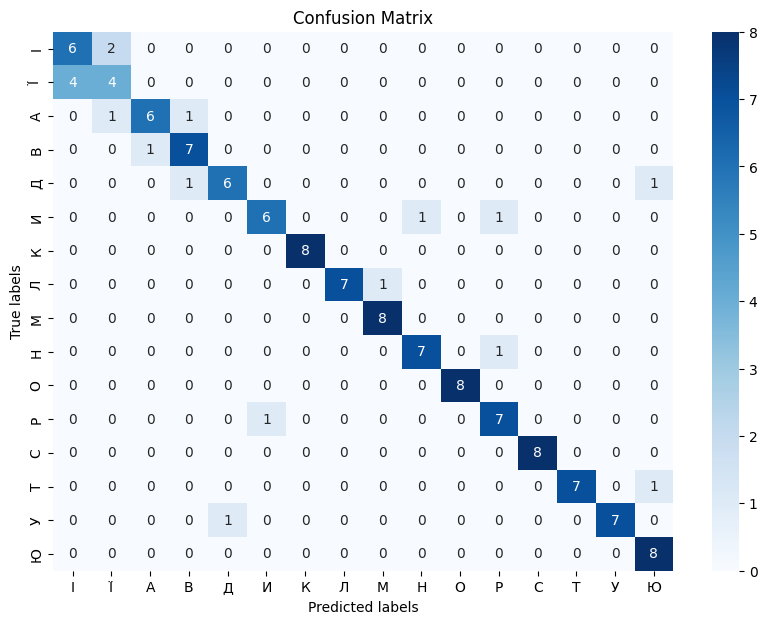

In [18]:
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)


conf_matrix = confusion_matrix(true_labels, predicted_classes)
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
x_tick_labels = [inverse_label_mapping[i] for i in range(len(conf_matrix))]
y_tick_labels = [inverse_label_mapping[i] for i in range(len(conf_matrix))]
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=x_tick_labels, yticklabels=y_tick_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()